## Build a Basic Chatbot with Langgraph(GRAPH API)

In [40]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END

from langgraph.graph.message import add_messages



In [41]:
class State(TypedDict):
    #messages have type'list' the add_messages function
    #annotation defines how this satte key should be updated
    #it appends mesages to list,rather than replacing it
    messages: Annotated[list,add_messages]
graph_builder=StateGraph(State)
#at any point of time we can create the entire graph we can provide info to diff node
    

In [42]:
graph_builder

In [43]:
##building graph
import os
from dotenv import load_dotenv
load_dotenv()

True

In [44]:
##define llm
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192",groq_api_key="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")

In [45]:
llm


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001BB3EC809D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001BB3EC81350>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [46]:
llm=init_chat_model("groq:llama3-8b-8192",groq_api_key="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")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001BB3EC81CD0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001BB3EC82650>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [47]:
##chatbot
##node functinality--input msg and give us response and append

def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}
    
    

In [48]:
##start building graph
graph_builder=StateGraph(State)
#node functionality--adding node to the graph
#specify the node name then functionality
graph_builder.add_node("llmchatbot",chatbot)
##adding edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

##COMPLILE GRAPH
graph=graph_builder.compile()

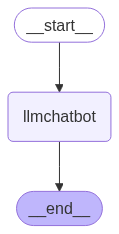

In [49]:
#visualise graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [50]:
response=graph.invoke({"messages":"Hi"})


In [51]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [52]:
##streaming it is in 2 ways
for event in graph.stream({"messages":"HI,how are you"}):
    for value in event.values():
        print(value["messages"][-1].content)
  

Hi! I'm just an AI, so I don't have emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! How about you? How's your day going?


In [53]:
## CHATBHOT WITH TOOL


## CHATBOT WITH TOOL

In [54]:
from langchain_tavily import TavilySearch
tool=TavilySearch(max_results=2)
tool.invoke("what is langgraph?")

{'query': 'what is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [55]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b
    

In [56]:
tools=[tool,multiply]

In [57]:
##binding llmwith tools
llm_with_tool=llm.bind_tools(tools)

In [58]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001BB3EC81CD0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001BB3EC82650>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

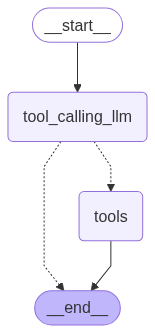

In [59]:
##tool used in chatbot node
##stategraph
from langgraph.graph import StateGraph,START,END
##ADDING TOOL
from langgraph.prebuilt import ToolNode
##tool to be converted to tool node
from langgraph.prebuilt import tools_condition

##node definition
def tool_calling_llm(state:State):
     return {"messages":[llm_with_tool.invoke(state["messages"])]}

##graph
builder=StateGraph(State)
##we need to 2nodes
builder.add_node("tool_calling_llm",tool_calling_llm) ##1. tool name,def
builder.add_node("tools",ToolNode(tools)) ##2. tool name,def

##edges 2 edges-end,tool they are conditional edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    ##2 condtions
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
    
)
builder.add_edge("tools",END)

##compile the graph

graph=builder.compile()

#visualise graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [60]:

response=graph.invoke({"messages":"What is the recent ai news"})

In [61]:
response["messages"][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://macholevante.com/ai-stock-frenzy-record-highs-bold-bets-and-backlash-in-late-july-2025/", "title": "AI Stock Frenzy: Record Highs, Bold Bets, and Backlash in Late July 2025 - Macholevante", "score": 0.71377134, "published_date": "Wed, 30 Jul 2025 09:10:35 GMT", "content": "In a headline announcement, leading AI chipmakers (including Huawei, Biren, Enflame, and Moore Threads) teamed up with top large-model developers (like StepFun and MiniMax) to form the **“Model-Chip Ecosystem Innovation Alliance.”** The goal of this alliance is to **standardize a homegrown AI tech stack** – linking **hardware and software** – so that Chinese AI labs can seamlessly swap in domestic chips for Nvidia’s and still run advanced AI models tomshardware.comtomshardware.com. **Sources:** Major financial news outlets and company reports (Bloomberg, Reuters, AP, Investopedia, TechCrunch) covering 

In [62]:
for  m in response['messages']:
    m.pretty_print()  # Use pretty_print to display the message content in a readable format

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (2sp2n6vqw)
 Call ID: 2sp2n6vqw
  Args:
    query: recent ai news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://macholevante.com/ai-stock-frenzy-record-highs-bold-bets-and-backlash-in-late-july-2025/", "title": "AI Stock Frenzy: Record Highs, Bold Bets, and Backlash in Late July 2025 - Macholevante", "score": 0.71377134, "published_date": "Wed, 30 Jul 2025 09:10:35 GMT", "content": "In a headline announcement, leading AI chipmakers (including Huawei, Biren, Enflame, and Moore Threads) teamed up with top large-model developers (like StepFun and MiniMax) to form the **“

In [63]:
response=graph.invoke({"messages":"what is 2 multiplied by 3 and then multiply 10?"})
for  m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiplied by 3 and then multiply 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (k5abcvbnv)
 Call ID: k5abcvbnv
  Args:
    a: 2
    b: 3
  multiply (5jn2j3fb4)
 Call ID: 5jn2j3fb4
  Args:
    a: 6
    b: 10
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: multiply

60


## reAct agent architecture

we here change the structure of graph here so that if we have different questions in same i/p that llm does toolcall get the response and search for the next question gets the response and then combine the outputs to give us the o/p---this is where we have agent this is called react agent architecture

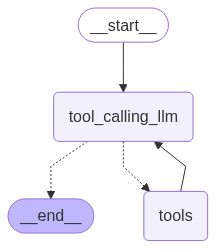

In [64]:

##stategraph
from langgraph.graph import StateGraph,START,END
##ADDING TOOL
from langgraph.prebuilt import ToolNode
##tool to be converted to tool node
from langgraph.prebuilt import tools_condition

##node definition
def tool_calling_llm(state:State):
     return {"messages":[llm_with_tool.invoke(state["messages"])]}

##graph
builder=StateGraph(State)
##we need to 2nodes
builder.add_node("tool_calling_llm",tool_calling_llm) ##1. tool name,def
builder.add_node("tools",ToolNode(tools)) ##2. tool name,def

##edges 2 edges-end,tool they are conditional edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    ##2 condtions
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
    
)
builder.add_edge("tools","tool_calling_llm")  # Loop back to tool_calling_llm if a tool call is made

##compile the graph

graph=builder.compile()

#visualise graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [65]:
response=graph.invoke({"messages":"what is recent ai news and then 5 multiply 10?"})
for  m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is recent ai news and then 5 multiply 10?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (nqp29c226)
 Call ID: nqp29c226
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://zamin.uz/en/technology/155797-nvidia-rival-groq-to-raise-big-in-ai-chip-race.html", "title": "NVIDIA rival Groq to raise big in AI chip race - Zamin.uz", "score": 0.70944256, "published_date": "Tue, 29 Jul 2025 23:28:00 GMT", "content": "Image 43: Tesla has signed a $16.5 billion (approx. 208 trillion Tesla signs $16.5B AI chip deal with Samsung Image 44Yesterday, 03:32\n\nImage 45: Facial recognition technology, once limited to id

## Adding Memory in Agentic Graph

In [66]:
##adding memmory solves major problm in agentic ai that is persistent checkpointing
response=graph.invoke({"messages":"Hello,i am phoebe"})
for  m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

Hello,i am phoebe
================================== Ai Message ==================================
Tool Calls:
  tavily_search (rx2katn2d)
 Call ID: rx2katn2d
  Args:
    query: define phoebe
================================= Tool Message =================================
Name: tavily_search

{"query": "define phoebe", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.merriam-webster.com/dictionary/phoebe", "title": "PHOEBE Definition & Meaning - Merriam-Webster", "content": "The meaning of PHOEBE is any of a genus (Sayornis) of the tyrant flycatcher family; especially : a flycatcher (S. phoebe) of the eastern U.S. that has a", "score": 0.8851659, "raw_content": null}, {"url": "https://en.wikipedia.org/wiki/Phoebe_(given_name)", "title": "Phoebe (given name) - Wikipedia", "content": "Phoebe or Phœbe is a female name, the feminine form of the male name Phoebus an e

In [67]:
##adding memory solves major problm in agentic ai that is persistent checkpointing
response=graph.invoke({"messages":"what is my name?"})
for  m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

I'm happy to help! However, I'm a large language model, I don't have the ability to know or remember your name. Each time you interact with me, it's a new conversation and I don't retain any information from previous conversations.

But if you'd like to introduce yourself, I'd be happy to chat with you!


to add memory saver checkpoint to have the entire information of the convo we have

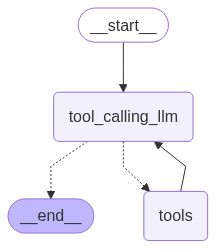

In [68]:

##stategraph
from langgraph.graph import StateGraph,START,END
##ADDING TOOL
from langgraph.prebuilt import ToolNode
##tool to be converted to tool node
from langgraph.prebuilt import tools_condition
##langgraph creates memory saver checkppoint
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

##node definition
def tool_calling_llm(state:State):
     return {"messages":[llm_with_tool.invoke(state["messages"])]}

##graph
builder=StateGraph(State)
##we need to 2nodes
builder.add_node("tool_calling_llm",tool_calling_llm) ##1. tool name,def
builder.add_node("tools",ToolNode(tools)) ##2. tool name,def

##edges 2 edges-end,tool they are conditional edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    ##2 condtions
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
    
)
builder.add_edge("tools","tool_calling_llm")  # Loop back to tool_calling_llm if a tool call is made

##compile the graph

graph=builder.compile(checkpointer=memory)

#visualise graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [69]:
##we create thread to use specific memory for previous conversation
## thread id is imp becoz it is related to one specific session
##we should have configurable key,thread with particuarkey value pair that should be unique
config={"configurable":{"thread_id":"1"}}
## make sure 
response=graph.invoke({"messages":"Hi my name is phoebe"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is phoebe', additional_kwargs={}, response_metadata={}, id='9c58e7ee-7fb1-44e2-afa4-f63b6472ebcf'),
  AIMessage(content='Nice to meet you, Phoebe!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 2907, 'total_tokens': 2917, 'completion_time': 0.00707975, 'prompt_time': 0.342608633, 'queue_time': 0.26691375800000006, 'total_time': 0.349688383}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--32c14abf-2606-49d4-b6e1-fcd853e0e692-0', usage_metadata={'input_tokens': 2907, 'output_tokens': 10, 'total_tokens': 2917})]}

In [70]:
response["messages"][-1].content

'Nice to meet you, Phoebe!'

In [71]:
response=graph.invoke({"messages":"what is my name "},config=config)

response["messages"][-1].content

'Your name is Phoebe.'

In [72]:
response=graph.invoke({"messages":"do you remember my name "},config=config)

response["messages"][-1].content

'Yes, your name is Phoebe.'

## Streaming

In [73]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [74]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

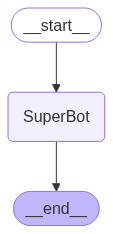

In [75]:
#graph
#node--superbot,compile with checkpointer memory
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [76]:
##create thred
##invoke it
config={"configurable": {"thread_id": "1"}}
graph_builder.invoke({"messages":"hi ,my name is phoebe and i like icecreams"},config)

{'messages': [HumanMessage(content='hi ,my name is phoebe and i like icecreams', additional_kwargs={}, response_metadata={}, id='2064d40d-0677-4c69-89a1-089c846fe439'),
  AIMessage(content="Hi Phoebe! It's great to meet you! Ice cream is definitely a popular treat that many people enjoy. Do you have a favorite flavor or brand of ice cream?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 24, 'total_tokens': 61, 'completion_time': 0.061000676, 'prompt_time': 0.004824975, 'queue_time': 0.266373137, 'total_time': 0.065825651}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--fbe01add-161d-4e79-ac62-10848b54d954-0', usage_metadata={'input_tokens': 24, 'output_tokens': 37, 'total_tokens': 61})]}


## Streaming
Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.
updates : This streams updates to the state of the graph after each node is called.

In [77]:
##using stream_mode='updates' -- u wil only get the current msg displayed,the last msg from ai , ai message mostly
##using stream_mode='values' -- u will get all the messages in the thread appending

# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is phoebe And I like icecreams"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Phoebe! Nice to meet you! Ah, ice cream lover, eh? What's your favorite flavor? Do you have a go-to spot for getting your ice cream fix, or do you like to try new and exciting flavors?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 24, 'total_tokens': 74, 'completion_time': 0.034363117, 'prompt_time': 0.004134615, 'queue_time': 0.266235356, 'total_time': 0.038497732}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--71a0f2eb-73b6-4477-a736-bb6acadcb337-0', usage_metadata={'input_tokens': 24, 'output_tokens': 50, 'total_tokens': 74})]}}


In [78]:
for chunk in graph_builder.stream({"messages":"Hi,my name is phoebe and i like icecreams"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is phoebe And I like icecreams', additional_kwargs={}, response_metadata={}, id='b8bca186-216f-4098-9715-debb8097ff7f'), AIMessage(content="Hi Phoebe! Nice to meet you! Ah, ice cream lover, eh? What's your favorite flavor? Do you have a go-to spot for getting your ice cream fix, or do you like to try new and exciting flavors?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 24, 'total_tokens': 74, 'completion_time': 0.034363117, 'prompt_time': 0.004134615, 'queue_time': 0.266235356, 'total_time': 0.038497732}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--71a0f2eb-73b6-4477-a736-bb6acadcb337-0', usage_metadata={'input_tokens': 24, 'output_tokens': 50, 'total_tokens': 74}), HumanMessage(content='Hi,my name is phoebe and i like icecreams', additional_kwargs={}, response_metadata={}, id

In [79]:
config = {"configurable": {"thread_id": "4"}}


for chunk in graph_builder.stream({'messages':"Hi,My name is phoebe And I like icecreams"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Phoebe! Nice to meet you! Ice cream is a great interest to have! What's your favorite flavor of ice cream? Do you have a go-to spot for getting your ice cream fix or do you like to try new places and flavors?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 24, 'total_tokens': 77, 'completion_time': 0.037233593, 'prompt_time': 0.003339246, 'queue_time': 0.266384354, 'total_time': 0.040572839}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--acf27313-6cf2-4c43-958b-5822b168129d-0', usage_metadata={'input_tokens': 24, 'output_tokens': 53, 'total_tokens': 77})]}}


In [80]:
for chunk in graph_builder.stream({'messages':"I also like dark chocolate"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is phoebe And I like icecreams', additional_kwargs={}, response_metadata={}, id='67b182e1-c59b-4794-9590-f369e5dbf036'), AIMessage(content="Hi Phoebe! Nice to meet you! Ice cream is a great interest to have! What's your favorite flavor of ice cream? Do you have a go-to spot for getting your ice cream fix or do you like to try new places and flavors?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 24, 'total_tokens': 77, 'completion_time': 0.037233593, 'prompt_time': 0.003339246, 'queue_time': 0.266384354, 'total_time': 0.040572839}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--acf27313-6cf2-4c43-958b-5822b168129d-0', usage_metadata={'input_tokens': 24, 'output_tokens': 53, 'total_tokens': 77}), HumanMessage(content='I also like dark chocolate', additional_kwargs={}, response_metada

In [81]:
##event for more detailed information using async

config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is phoebe and I like icecreams"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is phoebe and I like icecreams']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '9a036641-5e25-452c-aeea-fac322d1f5d1', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is phoebe and I like icecreams', additional_kwargs={}, response_metadata={}, id='85d58762-3952-4bb8-98c0-f034cc02aa11')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '515acbc9-e64a-4317-9424-543b0da85f4a', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:33f76d49-1056-a38d-65ac-acf3f2d1003d'}, 'parent_ids': ['9a036641-5e25-452c-aeea-fac322d1f5d1']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is phoebe and I like icecreams', add